# PARTIE II : Dual Attention Mode

This part contains **Depth Rebasing** and the **FOV Generator**. The result of it is the Depth Attention Map called $M_d$ and the FOV Attention Map named $M_f$.

## 1. Application of the Monocular Depth Estimator from ...

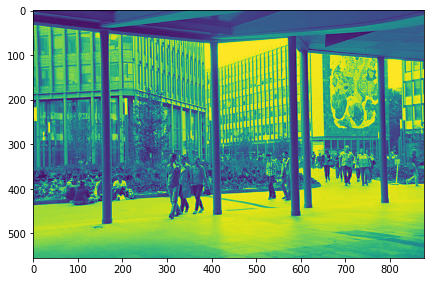

In [6]:
#Import of the project
import os
import glob

import argparse
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt

# Show one of the image, we are going to proceed
path = 'input/UPMC.jpg'

def extraction(chemin_fichier):
    # Extraction de l'image par OpenCV
    image = cv2.imread(chemin_fichier)
    return image

image = extraction(path)
image = image[:,:,0]
plt.figure(figsize=(7,7))
plt.imshow(image)
plt.show()

### Proceeding the Monocular Depth Estimator by taking the code from 

In [7]:
#Import of the Monocular Depth Estimator and the lib argparse
import argparse
from Monocular_libs import Monocular_depth_estimator_function

In [10]:
parser = argparse.ArgumentParser()

parser.add_argument('-i', '--input_path', 
    default='input',
    help='folder with input images'
)

parser.add_argument('-o', '--output_path', 
    default='output',
    help='folder for output images'
)

parser.add_argument('-m', '--model_weights', 
    default='model-f6b98070.pb',
    help='path to the trained weights of model'
)

parser.add_argument('-t', '--model_type', 
    default='small',
    help='model type: large or small'
)

args, unknown = parser.parse_known_args()

# compute depth maps
prediction = Monocular_depth_estimator_function.run(args.input_path, args.output_path, args.model_weights, args.model_type)


initialize
Last layer name:  1080_2:0
start processing
  processing input/UPMC.jpg (1/1)


ValueError: Cannot feed value of shape (1, 3, 256, 256) for Tensor '0:0', which has shape '(1, 3, 384, 384)'

In [ ]:
"""

import os
import glob
import cv2
import argparse
import tensorflow as tf

# Import from the libs of the Monocular Depth Estimator library
###############################################
#### /!\ Modify from the original code /!\ ####
###############################################
from Monocular_libs.transforms import Resize, NormalizeImage, PrepareForNet
from Monocular_libs import utils 
###############################################
#### /!\ Modify from the original code /!\ ####
###############################################

def run(input_path, output_path, model_path, model_type="large"):
    """Run MonoDepthNN to compute depth maps.

    Args:
        input_path (str): path to input folder
        output_path (str): path to output folder
        model_path (str): path to saved model"""

    print("initialize")

    # the runtime initialization will not allocate all memory on the device to avoid out of GPU memory
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus:
              #tf.config.experimental.set_memory_growth(gpu, True)
              tf.config.experimental.set_virtual_device_configuration(gpu,
                [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4000)])
        except RuntimeError as e:
            print(e)

    # network resolution
    if model_type == "large":
        net_w, net_h = 384, 384
    elif model_type == "small":
        net_w, net_h = 256, 256
    else:
        print(f"model_type '{model_type}' not implemented, use: --model_type large")
        assert False

    # load network
    graph_def = tf.compat.v1.GraphDef()
    with tf.io.gfile.GFile(model_path, 'rb') as f:
        graph_def.ParseFromString(f.read())
        tf.import_graph_def(graph_def, name='')

    
    model_operations = tf.compat.v1.get_default_graph().get_operations()
    input_node = '0:0'
    output_layer = model_operations[len(model_operations) - 1].name + ':0'
    print("Last layer name: ", output_layer)

    resize_image = Resize(
                net_w,
                net_h,
                resize_target=None,
                keep_aspect_ratio=False,
                ensure_multiple_of=32,
                resize_method="upper_bound",
                image_interpolation_method=cv2.INTER_CUBIC,
            )
    
    def compose2(f1, f2):
        return lambda x: f2(f1(x))

    transform = compose2(resize_image, PrepareForNet())

    # get input
    img_names = glob.glob(os.path.join(input_path, "*"))
    num_images = len(img_names)

    # create output folder
    os.makedirs(output_path, exist_ok=True)

    print("start processing")

    with tf.compat.v1.Session() as sess:
        try:
            # load images
            for ind, img_name in enumerate(img_names):

                print("  processing {} ({}/{})".format(img_name, ind + 1, num_images))

                # input
                img = utils.read_image(img_name)
                img_input = transform({"image": img})["image"]

                # compute
                prob_tensor = sess.graph.get_tensor_by_name(output_layer)
                prediction, = sess.run(prob_tensor, {input_node: [img_input] })
                prediction = prediction.reshape(net_h, net_w)
                prediction = cv2.resize(prediction, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_CUBIC)

                # output
                filename = os.path.join(
                    output_path, os.path.splitext(os.path.basename(img_name))[0]
                )
                utils.write_depth(filename, prediction, bits=2)
                
                ###############################################
                #### /!\ Modify from the original code /!\ ####
                ###############################################
                return prediction
                ###############################################
                #### /!\ Modify from the original code /!\ ####
                ###############################################

        except KeyError:
            print ("Couldn't find input node: ' + input_node + ' or output layer: " + output_layer + ".")
            exit(-1)

    print("finished")
    



if __name__ == "__main__":
    parser = argparse.ArgumentParser()

    parser.add_argument('-i', '--input_path', 
        default='input',
        help='folder with input images'
    )

    parser.add_argument('-o', '--output_path', 
        default='output',
        help='folder for output images'
    )

    parser.add_argument('-m', '--model_weights', 
        default='model-f6b98070.pb',
        help='path to the trained weights of model'
    )

    parser.add_argument('-t', '--model_type', 
        default='large',
        help='model type: large or small'
    )

    args, unknown = parser.parse_known_args()
    #args = parser.parse_args()

    # compute depth maps
    ###############################################
    #### /!\ Modify from the original code /!\ ####
    ###############################################
    prediction = run(args.input_path, args.output_path, args.model_weights, args.model_type)
    ###############################################
    #### /!\ Modify from the original code /!\ ####
    ###############################################
    """